In [1]:
from IPython.display import display, Math, Latex

import random
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from threading import Thread

# Sharpe Ratio Weight Calculator

* Calculates the best weight between any number of stocks using Monte Carlo methods & Sharpe Ratios

In [2]:
tickers = ["VFV.TO", "CWW.TO", "TEC.TO", "XEG.TO", "XFN.TO", "XRE.TO"]

# How much you want to invest
cash = 6000  # TFSA contribution room for 2022

In [3]:
ticker_hist = yf.download(
                tickers = " ".join([ticker for ticker in tickers]),
                # Download Data From the past 2 years
                period = "1y",
                interval = "5d",
                group_by = 'ticker',
                threads = True,
            )

[*********************100%***********************]  6 of 6 completed


In [4]:
# Drops all rows if and only if the entire row is empty.
ticker_hist.dropna(inplace=True)

ticker_hist.head()

TEC.TO                                                       \
                 Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2020-12-31  24.450001  24.450001  24.330000  24.440001  24.382753  21800.0   
2021-01-05  24.139999  24.320000  24.080000  24.200001  24.143318  45400.0   
2021-01-15  24.360001  24.430000  24.190001  24.209999  24.153290  50400.0   
2021-01-20  24.719999  25.020000  24.719999  24.980000  24.921488  66700.0   
2021-01-25  25.530001  25.590000  24.969999  25.469999  25.410341  65700.0   

               XFN.TO                                   ... XEG.TO        \
                 Open       High        Low      Close  ...    Low Close   
Date                                                    ...                
2020-12-31  38.410000  38.720001  38.360001  38.450001  ...   5.87  5.87   
2021-01-05  38.189999  38.410000  38.130001  38.320000  ...   5.98  6.38   
2021-01-15  39.490002  39.689999  39.360001  39.650002  ...   6.36  6.36   
2021-01-20  39.759998  39.759998  39.419998  39.660000  ...   6.33  6.38   
2021-01-25  38.910000  39.090000  38.750000  39.080002  ...   6.03  6.16   

                                    VFV.TO                                   \
           Adj Close     Volume       Open       High        Low      Close   
Date                                                                          
2020-12-31  5.759076   486200.0  84.300003  84.839996  84.080002  84.769997   
2021-01-05  6.259439  2578400.0  83.650002  84.099998  83.500000  83.779999   
2021-01-15  6.239818  1751900.0  85.339996  85.500000  84.900002  85.199997   
2021-01-20  6.259439   579600.0  86.430000  86.639999  85.910004  86.480003   
2021-01-25  6.043596  1685500.0  86.970001  87.199997  86.129997  87.199997   

                                 
            Adj Close    Volume  
Date                             
2020-12-31  83.790924   89300.0  
2021-01-05  82.812347  130800.0  
2021-01-15  84.215958  110400.0  
2021-01-20  85.481178  107300.0  
2021-01-25  86.192856  226600.0  

[5 rows x 36 columns]

## Determining Weights

Due to the immense number of possible permutations, we will have to run a monte carlo analysis to approximate the best weights, while quantifying the "best" weights using the generated portfolio's Sharpe Ratio:

$$ S=\frac{R_P-R_f}{\sigma_P} $$

#### Observe that:

$$ \Large{\frac{n_1}{\sum_{i=1}^{10} n_i} + \frac{n_2}{\sum_{i=1}^{10} n_i} + \ldots + \frac{n_{10}}{\sum_{i=1}^{10} n_i} = \text{1,  } \text{where } n \in \mathbb{R^+}} $$

### So what?
* This means that we can use this relationship to randomize our weightings. For example, if we had:
```
n1 =  random.random()
n2 =  random.random()
.
.
.
n10 =  random.random()
```

Then,
```
numbers = [n1, n2, ..., n10]
for number in numbers:
    number /= sum of numbers
```
And we then have that
```
sum(numbers) = 1
```

### The actual code to get this result is shown below

In [5]:
weightings = []

# Change these if you NEED exposure to all shares
min_weight = 0
max_weight = 1

# get_weight_list randomly generates a list of 10 numbers from 0 to 1 that correspond to the weightings of each stock
def get_weight_list():
    # We will pick 10 random numbers from a range of 100 numbers
    # random.sample is O(n), so we want to minimize this number
    
    random_num_list = random.sample(range(10000), len(tickers))
    listsum = sum(random_num_list)
    for i in range(len(random_num_list)):
        random_num_list[i] /= listsum
        
    # Check if the randomized weightings match those from the assignment's specifications.
    if (min(random_num_list) < min_weight) or (max(random_num_list) > max_weight):
        # If not, recurse back and try again
        return get_weight_list()
    else:
        return random_num_list

## Monte Carlo Analysissharpe_ratios = {}

In [6]:
sharpe_ratios = {}

In [7]:
def monte_carlo(weight_list, history, r_f=0):
    portfolio = pd.DataFrame(index=history.index)
    portfolio_shares = {}
    
    for i, ticker in enumerate(tickers):
        allocation = weight_list[i] * cash
        # Simulate purchasing the pre-inputted shares at the beginning of the time period
        initial_ticker_price = history[ticker].Close.iloc[0]
        shares = allocation / initial_ticker_price
        
        # Alongside this, create a portfolio of shares with the same weightings, but priced in the present.
        present_ticker_price = history[ticker].Close.iloc[-1]
        shares_present = allocation / present_ticker_price
        
        # Add weight to weight dictionary that collects all weights of this portfolio being generated
        portfolio_shares[ticker] = shares_present
        
        portfolio[ticker] = shares * history[ticker].Close
    
    portfolio.dropna(inplace=True)
    portfolio['Total Value'] = portfolio.sum(axis=1)
    portfolio['Percent Return'] = portfolio['Total Value'].pct_change() * 100

    std = portfolio['Percent Return'].std()
    avg_return = portfolio['Percent Return'].mean()
    
    sharpe_ratio = (avg_return - r_f) / std
    return (sharpe_ratio, portfolio_shares)
    

def run_monte_carlo(ticker_hist):
    weights = get_weight_list()
    result = monte_carlo(weights, ticker_hist)
    sharpe_ratios[result[0]] = result[1]

In [8]:
# Number of trials, more will give you better results, but may take longer
trials = 100000

# Threaded Calls

threads = []

for i in range(trials):
    thread = Thread(target=run_monte_carlo, args=(ticker_hist,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

optimal_weight = sharpe_ratios[max(sharpe_ratios.keys())]

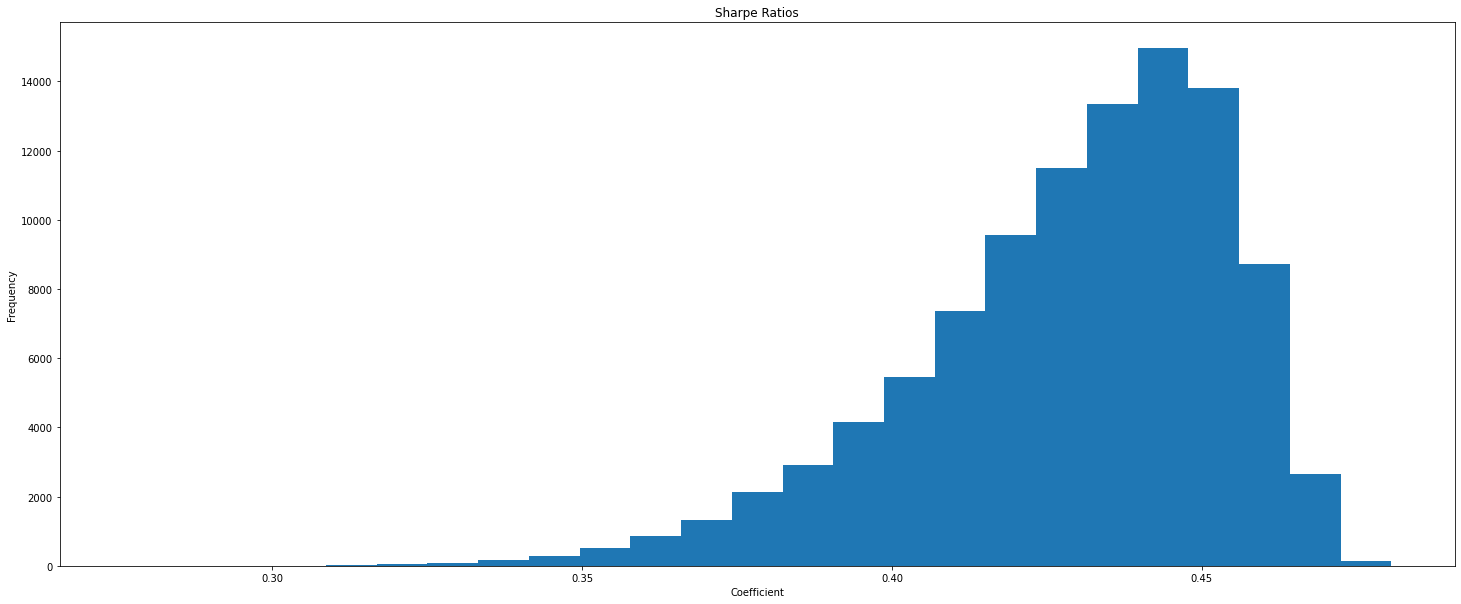

In [9]:
#Plots the distribution of sharpe ratios
plt.figure(figsize=(25,10))

plt.hist(sharpe_ratios, bins=25)
plt.title('Sharpe Ratios')
plt.xlabel('Coefficient')
plt.ylabel('Frequency')

plt.show()

In [10]:
# Moves final_optimal_weight into a dataframe.
final_stocks_df = pd.DataFrame.from_dict(optimal_weight, orient='index')
final_stocks_df.reset_index(inplace=True)
final_stocks_df.columns = ['Ticker', 'Shares']
final_stocks_df

,Ticker,Shares
0,VFV.TO,32.714150
1,CWW.TO,2.881649
2,TEC.TO,6.452132
3,XEG.TO,50.067182
4,XFN.TO,16.998577
5,XRE.TO,36.010784
